In [0]:
import json
import numpy as np
import math
import tensorflow.compat.v1 as tf 
import string
import random
import nltk
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/riset NLP/Covid 19')
!ls -a

'content summaries.png'  'dist summary'        ' preprocessing.ipynb'
'content word.png'	 'dist summary.png'     ProcessedData.json
 data_res_test_1.csv	  glove.840B.300d.txt   scoring.ipynb
 data_res_test_2.csv	  Model_Backup	        splitting.png
 data_res_test_3.csv	  modelling.ipynb      'train loss.png'
'dist content'		 'news cleaned.csv'
'dist content.png'	  news.csv


In [0]:
with open ('ProcessedData.json') as fp:
    diction = json.load(fp)

In [0]:
vocab = diction['vocab']
embd = diction['embd']
train_batches_x = diction['train_batches_x']
train_batches_y = diction['train_batches_y']
val_batches_x = diction['val_batches_x']
val_batches_y = diction['val_batches_y']
test_batches_x = diction['test_batches_x']
test_batches_y = diction['test_batches_y']
train_batches_in_lens = diction['train_batches_in_len']
train_batches_out_lens = diction['train_batches_out_len'] 
val_batches_in_lens = diction['val_batches_in_len']
val_batches_out_lens = diction['val_batches_out_len']
test_batches_in_lens = diction['test_batches_in_len']
test_batches_out_lens = diction['test_batches_out_len']
vocab_len = len(vocab)
vocab2idx = {word:idx for idx,word in enumerate(vocab)}
idx2vocab = {idx:word for word,idx in vocab2idx.items()}
embeddings = np.asarray(embd,dtype=np.float32)
word_vec_dim = embeddings.shape[-1]

In [0]:
tf.disable_v2_behavior()
tf.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
#Hyperparamters

heads = 10
max_pos_len = 5000
learning_rate=1e-5
epochs = 100
fc_dim = 512
dropout_rate=0.1
attention_dropout_rate=0.1
encoder_layers = 6
decoder_layers = 6

#Placeholders

tf_texts = tf.placeholder(tf.int32, [None,None])
tf_summaries = tf.placeholder(tf.int32, [None,None])
tf_text_lens = tf.placeholder(tf.int32,[None])
tf_summary_lens = tf.placeholder(tf.int32,[None])
tf_teacher_forcing = tf.placeholder(tf.bool)
tf_train = tf.placeholder(tf.bool)
tf_no_eval = tf.placeholder(tf.bool)

In [0]:
def gelu(x):
    return 0.5 * x * (1 + tf.nn.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

In [0]:
def dropout(x,rate,training):
    return tf.cond(training,
                  lambda: tf.nn.dropout(x,rate=rate),
                  lambda:x)

In [0]:
def layerNorm(inputs, dim, name):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE, dtype=tf.float32):
        scale = tf.get_variable("scale", shape=[1, 1, dim],
                                dtype=tf.float32,
                                initializer=tf.ones_initializer())

        shift = tf.get_variable("shift", shape=[1, 1, dim],
                                dtype=tf.float32,
                                initializer=tf.zeros_initializer())

    mean, var = tf.nn.moments(inputs, [-1], keep_dims=True)

    epsilon = 1e-9

    LN = tf.multiply((scale / tf.sqrt(var + epsilon)), (inputs - mean)) + shift

    return LN

In [0]:
def spatial_encoding(D):
    
    global max_pos_len
    
    S = max_pos_len

    pe = np.zeros((2*S+1, D,), np.float32)

    for pos in range(-S, S+1):
        for i in range(0, D):
            if i % 2 == 0:
                pe[pos+S, i] = math.sin(pos/(10000**(i/D)))
            else:
                pe[pos+S, i] = math.cos(pos/(10000**((i-1)/D)))

    return tf.constant(pe.reshape((2*S+1, D)), tf.float32)

PE = spatial_encoding(word_vec_dim)

In [0]:
def create_mask(Q,V,Q_mask,V_mask,neg_inf = -2.0**32):
    
    global heads
    
    N = tf.shape(Q)[0]
    qS = tf.shape(Q)[1]
    vS = tf.shape(V)[1]

    y = tf.zeros([N, qS, vS], tf.float32)
    x = tf.cast(tf.fill([N, qS, vS], neg_inf), tf.float32)

    binary_mask = tf.reshape(V_mask, [N, 1, vS])
    binary_mask = tf.tile(binary_mask, [1, qS, 1])
    binary_mask = binary_mask*Q_mask

    mask = tf.where(tf.equal(binary_mask, tf.constant(0, tf.float32)),
                    x=x,
                    y=y)

    mask = tf.reshape(mask, [1, N, qS, vS])
    mask = tf.tile(mask, [heads, 1, 1, 1])
    mask = tf.reshape(mask, [heads*N,qS,vS])

    return mask

In [0]:

def generate_relative_embd(qS,vS,embeddings):
    
    global max_pos_len
    
    S = tf.maximum(qS,vS)

    range_vec = tf.reshape(tf.range(S), [1, S])
    range_mat = tf.tile(range_vec, [S, 1])

    relative_pos_mat = range_mat - tf.transpose(range_mat)
    relative_pos_mat = relative_pos_mat[0:qS,0:vS]

    relative_pos_mat_shifted = relative_pos_mat + max_pos_len
    # will represent -max_pos_len by 0,-max_pos_len+1 by 1, and so on

    RE = tf.nn.embedding_lookup(embeddings, relative_pos_mat_shifted)

    return RE

In [0]:
def multiheaded_attention(Q,V,
                          true_q_len,true_v_len,
                          train,name,
                          causal=False,
                          current_timestep=1,
                          current_depth=1,
                          attention_dropout_rate = 0.1):
    
    global heads
    global PE # position encoding
    global word_vec_dim
    global vocab2idx
    
    PRED = vocab2idx['<PRED>']

    N = tf.shape(Q)[0]
    qS = tf.shape(Q)[1]
    vS = tf.shape(V)[1]
    D = word_vec_dim

    d = D//heads

    Q_mask = tf.sequence_mask(true_q_len, maxlen=qS, dtype=tf.float32)
    Q_mask = tf.reshape(Q_mask, [N, qS, 1])

    V_mask = tf.sequence_mask(true_v_len, maxlen=vS, dtype=tf.float32)
    V_mask = tf.reshape(V_mask, [N, vS, 1])
    
    if causal:
        attention_len = tf.tile(tf.reshape(current_timestep+1,[1]),[N])
        causal_mask = tf.sequence_mask(attention_len, maxlen=vS, dtype=tf.float32)
        causal_mask = tf.reshape(causal_mask,[N,vS,1])
        
        Q_mask = tf.ones([1,1,1],tf.float32)
        
        attention_mask = create_mask(Q,V,Q_mask,V_mask*causal_mask)
    else:
        attention_mask = create_mask(Q,V,Q_mask,V_mask)
    
    l = current_depth

    init = tf.initializers.variance_scaling(
        scale=1/l, mode='fan_avg', distribution='uniform')

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE, dtype=tf.float32):

        Wq = tf.get_variable("Wq", [heads, D,  d],
                             dtype=tf.float32, initializer=init)

        Wk = tf.get_variable("Wk", [heads, D, d],
                             dtype=tf.float32, initializer=init)

        Wv = tf.get_variable("Wv", [heads, D, d],
                             dtype=tf.float32, initializer=init)

        Wq = tf.transpose(Wq, [1, 0, 2])
        Wq = tf.reshape(Wq, [D, heads*d])

        Wk = tf.transpose(Wk, [1, 0, 2])
        Wk = tf.reshape(Wk, [D, heads*d])

        Wv = tf.transpose(Wv, [1, 0, 2])
        Wv = tf.reshape(Wv, [D, heads*d])

        Wo = tf.get_variable("Wo", [heads*d, D],
                             dtype=tf.float32, initializer=init)

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE, dtype=tf.float32):

        u = tf.get_variable("u_bias", [heads, 1, 1, d],
                            dtype=tf.float32, initializer=tf.zeros_initializer())

        v = tf.get_variable("v_bias", [heads, 1, 1, d],
                            dtype=tf.float32, initializer=tf.zeros_initializer())

        Wrk = tf.get_variable("Wrk", [heads, D, d],
                              dtype=tf.float32, initializer=tf.glorot_uniform_initializer())

        Wrk = tf.transpose(Wrk, [1,0,2])
        Wrk = tf.reshape(Wrk, [D, heads*d])


    Q = tf.reshape(Q*Q_mask, [N*qS, D])
    K = tf.reshape(V*V_mask, [N*vS, D])
    V = tf.reshape(V*V_mask, [N*vS, D])

    Q = tf.matmul(Q, Wq)
    K = tf.matmul(K, Wk)
    V = tf.matmul(V, Wv)

    Q = tf.reshape(Q, [N, qS, heads*d])
    K = tf.reshape(K, [N, vS, heads*d])
    V = tf.reshape(V, [N, vS, heads*d])
    
    # Turn to head x N x S x d format

    Q = tf.concat(tf.split(Q, heads, axis=-1), axis=0)  
    K = tf.concat(tf.split(K, heads, axis=-1), axis=0)  
    V = tf.concat(tf.split(V, heads, axis=-1), axis=0)  

    # ATTENTION

    Q = tf.reshape(Q, [heads, N, qS, d])
    Qc = tf.reshape(Q+u, [heads*N, qS, d])

    content_scores = tf.matmul(Qc, tf.transpose(K, [0, 2, 1]))

    PEk = tf.matmul(PE, Wrk)
    REk = generate_relative_embd(qS,vS,PEk)

    REk = tf.reshape(REk, [qS, vS, heads, d])
    REk = tf.transpose(REk, [2, 0, 1, 3])

    Qr = Q+v
    Qr = tf.transpose(Qr, [0, 2, 1, 3])
    position_scores = tf.matmul(Qr, tf.transpose(REk, [0, 1, 3, 2]))
    position_scores = tf.transpose(position_scores, [0, 2, 1, 3])
    position_scores = tf.reshape(position_scores, [heads*N, qS, vS])

    compatibility = content_scores + position_scores

    scalar_d = tf.sqrt(tf.constant(d, tf.float32))

    compatibility = (content_scores + position_scores)/scalar_d

    compatibility = compatibility+attention_mask
    compatibility = tf.nn.softmax(compatibility,axis=-1)

    compatibility = dropout(compatibility, rate=attention_dropout_rate, training=train)

    attended_content = tf.matmul(compatibility, V)

    attended_heads = attended_content
    
    # Convert to form N x S x heads*d
    
    attended_heads = tf.concat(tf.split(attended_heads, heads, axis=0), axis=2)
    attended_heads = tf.reshape(attended_heads, [N*qS, heads*d])

    head_composition = tf.matmul(attended_heads, Wo)

    head_composition = tf.reshape(head_composition, [N, qS, D])
    
    return head_composition

In [0]:
def encoder_layer(Q, true_q_len, current_depth, train, name):

    global word_vec_dim
    global fc_dim
    global dropout_rate
    global attention_dropout_rate
    
    D = word_vec_dim
    l = current_depth
    
    N = tf.shape(Q)[0]
    qS = tf.shape(Q)[1]

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE, dtype=tf.float32):

        init = tf.initializers.variance_scaling(scale=1/l, mode='fan_avg', distribution='uniform')

        W1 = tf.get_variable("W1", [D, fc_dim], dtype=tf.float32,
                             initializer=init)
        B1 = tf.get_variable("Bias1", [fc_dim], dtype=tf.float32,
                             initializer=tf.zeros_initializer())

        W2 = tf.get_variable("W2", [fc_dim, D], dtype=tf.float32,
                             initializer=init)
        B2 = tf.get_variable("Bias2", [D], dtype=tf.float32,
                             initializer=tf.zeros_initializer())


    Q = layerNorm(Q, D, name+"/layer_norm1")

    sublayer1 = multiheaded_attention(Q=Q,V=Q,
                                      true_q_len=true_q_len,
                                      true_v_len=true_q_len,
                                      train=train,name=name,
                                      causal=False,
                                      current_depth=current_depth,
                                      attention_dropout_rate=attention_dropout_rate)

    sublayer1 = dropout(sublayer1, rate=dropout_rate, training=train)
    sublayer1 = layerNorm(sublayer1+Q, D, name+"/layer_norm2")

    sublayer2 = tf.reshape(sublayer1, [N*qS, D])
    sublayer2 = gelu(tf.matmul(sublayer2, W1)+B1)
    sublayer2 = tf.matmul(sublayer2, W2)+B2

    sublayer2 = tf.reshape(sublayer2, [N, qS, D])
    sublayer2 = dropout(sublayer2, rate=dropout_rate, training=train)
    sublayer2 = sublayer2 + sublayer1

    return sublayer2

In [0]:
def decoder_layer(encoder_Q,decoder_Q, 
                  true_encoder_len,true_decoder_len,
                  timestep,
                  current_depth, train, name):

    global word_vec_dim
    global fc_dim
    global dropout_rate
    global attention_dropout_rate
    
    D = word_vec_dim
    l = current_depth
    
    N = tf.shape(decoder_Q)[0]
    qS = tf.shape(decoder_Q)[1]

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE, dtype=tf.float32):

        init = tf.initializers.variance_scaling(scale=1/l, mode='fan_avg', distribution='uniform')

        W1 = tf.get_variable("W1", [D, fc_dim], dtype=tf.float32,
                             initializer=init)
        B1 = tf.get_variable("Bias1", [fc_dim], dtype=tf.float32,
                             initializer=tf.zeros_initializer())
        W2 = tf.get_variable("W2", [fc_dim, D], dtype=tf.float32,
                             initializer=init)
        B2 = tf.get_variable("Bias2", [D], dtype=tf.float32,
                             initializer=tf.zeros_initializer())

    decoder_Q = layerNorm(decoder_Q, D, name+"/layer_norm1")

    sublayer1 = multiheaded_attention(Q=decoder_Q,V=decoder_Q,
                                      true_q_len=true_decoder_len,
                                      true_v_len=true_decoder_len,
                                      train=train,
                                      name=name+"_self_attention",
                                      causal=True,
                                      current_timestep=timestep,
                                      current_depth=current_depth,
                                      attention_dropout_rate=attention_dropout_rate)

    sublayer1 = dropout(sublayer1, rate=dropout_rate, training=train)
    sublayer1 = layerNorm(sublayer1+decoder_Q, D, name+"/layer_norm2")
    
    sublayer2 = multiheaded_attention(Q=sublayer1,V=encoder_Q,
                                      true_q_len=true_decoder_len,
                                      true_v_len=true_encoder_len,
                                      train=train,
                                      name=name+"_interlayer_attention",
                                      causal=False,
                                      current_timestep=timestep,
                                      current_depth=current_depth,
                                      attention_dropout_rate=attention_dropout_rate)
    
    sublayer2 = dropout(sublayer2, rate=dropout_rate, training=train)
    sublayer2 = layerNorm(sublayer2+sublayer1, D, name+"/layer_norm3")

    sublayer3 = tf.reshape(sublayer2, [N*qS, D])
    sublayer3 = gelu(tf.matmul(sublayer3, W1)+B1)
    sublayer3 = tf.matmul(sublayer3, W2)+B2

    sublayer3 = tf.reshape(sublayer3, [N, qS, D])
    sublayer3 = dropout(sublayer3, rate=dropout_rate, training=train)
    sublayer3 = sublayer3 + sublayer2

    return sublayer3

In [0]:
def encode(Q, true_q_len, current_depth, train, name):
    
    global encoder_layers
    layers = encoder_layers
    
    
    Q = dropout(Q, rate=dropout_rate, training=train)

    for t in range(layers):
        Q = encoder_layer(Q=Q, 
                          true_q_len=true_q_len, 
                          current_depth=current_depth+t, 
                          train=train, 
                          name=name+"_"+str(t))
        
    return Q, current_depth+layers

In [0]:
def decode(encoder_Q,decoder_Q, true_encoder_len, timestep, current_depth, train, name):
    
    global decoder_layers
    layers = decoder_layers
    
    N = tf.shape(decoder_Q)[0]
    qS = tf.shape(decoder_Q)[1]
    
    true_decoder_len = tf.tile(tf.reshape(qS,[1]),[N])
    
    for t in range(layers):
        decoder_Q = decoder_layer(encoder_Q=encoder_Q,
                                  decoder_Q=decoder_Q, 
                                  true_encoder_len=true_encoder_len,
                                  true_decoder_len=true_decoder_len,
                                  timestep=timestep,
                                  current_depth=current_depth+t,
                                  train=train, 
                                  name=name+"_"+str(t))
        
    return decoder_Q, current_depth+layers

In [0]:
def encoder_decoder(texts,summaries,
                    true_text_lens,true_summary_lens,
                    train,
                    no_eval):
    
    global vocab2idx
    global word_vec_dim
    global tf_teacher_forcing
    
    GO = vocab2idx['<GO>']
    PRED = vocab2idx['<PRED>']
    
    N = tf.shape(texts)[0]
    D = word_vec_dim
    
    tf_embd = tf.convert_to_tensor(embeddings)
    tf_softmax_wt = tf.transpose(tf_embd,[1,0])
    texts = tf.nn.embedding_lookup(tf_embd,texts)
    
    Q,current_depth = encode(Q=texts,
                            true_q_len=true_text_lens,
                            current_depth=1,
                            train=train,
                            name="Enocder")
    
    encoder_Q = layerNorm(Q, D, "encoder_layer_norm")
    
    decoder_Q = tf.constant([GO,PRED],tf.int32)
    decoder_Q = tf.nn.embedding_lookup(tf_embd,decoder_Q)
    decoder_Q = tf.reshape(decoder_Q,[1,2,D])
    decoder_Q = tf.tile(decoder_Q,[N,1,1])
    
    
    PRED_embd = tf.reshape(decoder_Q[:,-1,:],[N,1,D])
    
    i=tf.constant(0)
                           
    decode_length = tf.cond(no_eval,
                            lambda: tf.constant(22,tf.int32),
                            lambda: tf.shape(summaries)[1])
                           
    logits=tf.TensorArray(size=1, dynamic_size=True, dtype=tf.float32)
    predictions=tf.TensorArray(size=1, dynamic_size=True, dtype=tf.int32)
                           
    
    def cond(i,decoder_Q,logits,predictions):
        return i<decode_length
    
    def body(i,decoder_Q,logits,predictions):

                           
        decoder_Q,_ = decode(encoder_Q=encoder_Q,
                                       decoder_Q=decoder_Q, 
                                       true_encoder_len=true_text_lens, 
                                       timestep=i, 
                                       current_depth=current_depth, 
                                       train=train, 
                                       name="Decoder")

                           
        decoderout = decoder_Q[:,tf.shape(decoder_Q)[1]-1,:]
                           
        out_prob_dist = tf.matmul(decoderout,tf_softmax_wt)
                           
        
        
        pred_idx = tf.cast(tf.argmax(out_prob_dist,axis=-1),tf.int32)
        
        logits = logits.write(i,out_prob_dist)
        predictions = predictions.write(i,pred_idx)
        
        next_idx = tf.cond(tf_teacher_forcing,
                           lambda: summaries[:,i],
                           lambda: pred_idx)
        
        
                           
        next_embd = tf.nn.embedding_lookup(tf_embd,next_idx)
        next_embd = tf.reshape(next_embd,[N,1,D])
                           
        decoder_Q = tf.concat([decoder_Q[:,0:-1,:],next_embd,PRED_embd],axis=1)
           
        
        return i+1,decoder_Q,logits,predictions
    
    _,_,logits,predictions = tf.while_loop(cond,body,[i,decoder_Q,logits,predictions],
                                          shape_invariants=[i.get_shape(),
                                                            tf.TensorShape([None,None,D]),
                                                            tf.TensorShape(None),
                                                            tf.TensorShape(None)])
    
    logits = logits.stack()
    logits = tf.transpose(logits,[1,0,2])
    predictions = predictions.stack()
    predictions = tf.transpose(predictions,[1,0])

    return logits,predictions

In [0]:
# Construct Model
logits, predictions = encoder_decoder(tf_texts,tf_summaries,
                                      tf_text_lens,tf_summary_lens,
                                      tf_train,
                                      tf_no_eval)

#OPTIMIZER
trainables = tf.trainable_variables()
beta=1e-7

regularization = tf.reduce_sum([tf.nn.l2_loss(var) for var in trainables])

pad_mask = tf.sequence_mask(tf_summary_lens, maxlen=tf.shape(tf_summaries)[1], dtype=tf.float32)

cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf_summaries)
cost = tf.multiply(cost,pad_mask) #mask used to remove loss effect due to PADS
cost = tf.reduce_mean(cost) + beta*regularization

optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=learning_rate,beta1=0.8,beta2=0.88,epsilon=1e-8,
    name='Adam'
).minimize(cost)

# optimizer = tf.compat.v1.train.AdagradOptimizer(
#     learning_rate=learning_rate, initial_accumulator_value=0.1, use_locking=False, name='Adagrad'
# ).minimize(cost)

"""temperature = 0.7
scaled_output = tf.log(logits)/temperature
logits = tf.nn.softmax(scaled_output)"""

#(^Use it with "#prediction_int = np.random.choice(range(vocab_len), p=array.ravel())")

'temperature = 0.7\nscaled_output = tf.log(logits)/temperature\nlogits = tf.nn.softmax(scaled_output)'

In [0]:
!pip install rouge-score
import string
import random
from rouge_score import rouge_scorer

In [0]:
init = tf.global_variables_initializer()
loss_train = []
loss_eval = []

with tf.Session() as sess: # Start Tensorflow Session
    
    saver = tf.train.Saver() 
    # Prepares variable for saving the model
    sess.run(init) #initialize all variables
    step = 0   
    best_ROUGE = 0
    display_step = 500
    scorer = rouge_scorer.RougeScorer(['rouge1'])

    while step < epochs:
           
        batch_len = len(train_batches_x)
        rand_idx = [idx for idx in range(batch_len)]
        random.shuffle(rand_idx)
        #rand_idx = rand_idx[0:2000]
        count=0
        batches_loss_train = []
        for i in rand_idx: 
            
            batch_size = len(train_batches_x[i])
            
            sample_no = np.random.randint(0,batch_size)
            
            if count%display_step==0:
                print("\nEpoch: "+str(step+1)+" Iteration: "+str(count+1))
                print("\nCHOSEN SAMPLE NO.: "+str(sample_no))
                print("\nSAMPLE TEXT:")
                for vec in train_batches_x[i][sample_no]:
                    print(str(idx2vocab[vec]),end=" ")
                print("\n")
                
            
                
            rand = random.randint(0,4) #determines chance of using Teacher Forcing
            if rand==2:
                random_bool = False
            else:
                random_bool = True

            train_batch_x = np.asarray(train_batches_x[i],np.int32)
            train_batch_y = np.asarray(train_batches_y[i],np.int32)
            train_batch_in_lens = np.asarray(train_batches_in_lens[i],np.int32)
            train_batch_out_lens = np.asarray(train_batches_out_lens[i],np.int32)
    
            _,loss,out = sess.run(
                    [optimizer,cost,logits],
                    feed_dict={
                        tf_texts: train_batch_x, 
                        tf_summaries: train_batch_y,
                        tf_text_lens: train_batch_in_lens,
                        tf_summary_lens: train_batch_out_lens,
                        tf_train: True,
                        tf_no_eval: False,
                        tf_teacher_forcing: random_bool
                        }
                    )
            batches_loss_train.append(loss)
            if count%display_step==0:
                print("\nPREDICTED SUMMARY OF THE SAMPLE:\n")
                flag = 0
                for array in out[sample_no]:
                    
                    #prediction_int = np.random.choice(range(vocab_len), p=array.ravel()) 
                    #(^use this if you want some variety)
                    #(or use this what's below:)
                    
                    prediction_int = np.argmax(array)
                    
                    if vocab[prediction_int] in string.punctuation or flag==0: 
                        print(str(vocab[prediction_int]),end='')
                    else:
                        print(" "+str(vocab[prediction_int]),end='')
                    flag=1
                print("\n")
                
                print("ACTUAL SUMMARY OF THE SAMPLE:\n")
                for vec in train_batches_y[i][sample_no]:
                    print(str(idx2vocab[vec]),end=" ")
                print("\n")
            
                print("loss="+str(loss))
                
            count+=1
        loss_train.append(np.average(batches_loss_train))        
        print("\n\nSTARTING VALIDATION\n\n")
                
        batch_len = len(val_batches_x)
        #print(batch_len)
        total_ROUGE_argmax=0
        batches_loss_eval = []
        total_len=0
        for i in range(0,batch_len):
            
            batch_size = len(val_batches_x[i])
            
            sample_no = np.random.randint(0,batch_size)

            if i%display_step==0:
                print("\nEpoch: "+str(step+1)+" Iteration: "+str(i+1))
                print("\nCHOSEN SAMPLE NO.: "+str(sample_no))
                print("\nSAMPLE TEXT:")
                for vec in val_batches_x[i][sample_no]:
                    print(str(idx2vocab[vec]),end=" ")
                print("\n")
                
            
            val_batch_x = np.asarray(val_batches_x[i],np.int32)
            val_batch_y = np.asarray(val_batches_y[i],np.int32)
            val_batch_in_lens = np.asarray(val_batches_in_lens[i],np.int32)
            val_batch_out_lens = np.asarray(val_batches_out_lens[i],np.int32)
       
            loss,out = sess.run([cost,logits],feed_dict={tf_texts: val_batch_x, 
                                                         tf_summaries: val_batch_y,
                                                         tf_text_lens: val_batch_in_lens,
                                                         tf_summary_lens: val_batch_out_lens,
                                                         tf_no_eval: False,
                                                         tf_train: False,
                                                         tf_teacher_forcing: False})
            batches_loss_eval.append(loss)
            batch_summaries = val_batch_y
            batch_argmax_preds = np.argmax(out,axis=-1)

            batch_ROUGE_argmax = 0
            batch_ROUGE_argmax_list=[]
            
            for summary, argmax_pred in zip(batch_summaries, batch_argmax_preds):

                str_summary = ""
                str_predicted_summary = ""                
                gold_EOS_flag = 0
                new_line_flag = 0
                for t in range(len(summary)):

                    if gold_EOS_flag == 0:

                        gold_idx = summary[t]
                        argmax_idx = argmax_pred[t]

                        if idx2vocab.get(gold_idx, '<UNK>') == "<EOS>":
                            gold_EOS_flag = 1
                        else:
                          if(new_line_flag==0):
                            str_summary = str(gold_idx)
                            str_predicted_summary = str(argmax_idx)
                            new_line_flag = 1                      
                          else:
                            str_summary += " " + str(gold_idx)
                            str_predicted_summary +=  " " + str(argmax_idx)

                score = scorer.score(str_summary, str_predicted_summary)
                ROUGE_1_f = score["rouge1"].fmeasure
                batch_ROUGE_argmax += ROUGE_1_f
                batch_ROUGE_argmax_list.append(ROUGE_1_f)

            total_ROUGE_argmax += batch_ROUGE_argmax
            total_len += batch_size
            if i%display_step==0:
                print("\nPREDICTED SUMMARY OF THE SAMPLE:\n")
                flag = 0
                for array in out[sample_no]:
                    
                    #prediction_int = np.random.choice(range(vocab_len), p=array.ravel()) 
                    #(^use this if you want some variety)
                    #(or use this what's below:)
                    
                    prediction_int = np.argmax(array)
                    
                    if vocab[prediction_int] in string.punctuation or flag==0: 
                        print(str(vocab[prediction_int]),end='')
                    else:
                        print(" "+str(vocab[prediction_int]),end='')
                    flag=1
                print("\n")
                
                print("ACTUAL SUMMARY OF THE SAMPLE:\n")
                for vec in val_batches_y[i][sample_no]:
                    print(str(idx2vocab[vec]),end=" ")
                print("\n")
            
                print("loss="+str(loss))
                print("ROUGE-1=",batch_ROUGE_argmax_list[sample_no])
        loss_eval.append(np.average(batches_loss_eval))
        avg_ROUGE = total_ROUGE_argmax/total_len
        print("AVERAGE VALIDATION ROUGE:",avg_ROUGE)
        
        if(avg_ROUGE>=best_ROUGE):
            best_ROUGE = avg_ROUGE
            saver.save(sess, 'Model_Backup/allattmodel_3.ckpt')
            print("\nCheckpoint Created\n")

        step=step+1


Epoch: 1 Iteration: 1

CHOSEN SAMPLE NO.: 5

SAMPLE TEXT:
medical experts are warning canadians not to believe the <UNK> a hidden camera <UNK> winnipeg acupuncturist was selling <UNK> tea that he claims can prevent <UNK> . in an email blast to clients last week , <UNK> huang , an acupuncture therapist and specialist in traditional chinese medicine , said drinking a blend of six herbs in a tea over six days would keep people safe . `` <UNK> is here . so is herb tea to prevent <UNK> , '' said the email , which was sent march 18. it told clients of the acupuncture clinic to `` order your coronavirus prevention tea now . '' a facebook post from the same day made a similar claim . `` this is quite outrageous , '' said cedric cheung , the national president of the chinese medicine and acupuncture association of canada , when told about the claim . `` you can not make a statement that can possibly mislead a patient . '' ankang acupuncture healing centre emailed customers on march 18 claiming

In [0]:
init = tf.global_variables_initializer()
data_predicted = []

with tf.Session() as sess: # Start Tensorflow Session
    saver = tf.train.Saver() 
    saver.restore(sess, 'Model_Backup/allattmodel_3.ckpt')
    #sess.run(init) #initialize all variables
    print("Checkpoint Restored")
    print("STARTING TEST")
    batch_len = len(test_batches_x)
    total_len=0
    for i in range(0,batch_len):
        
        batch_size = len(test_batches_x[i])

        test_batch_x = np.asarray(test_batches_x[i],np.int32)
        test_batch_y = np.asarray(test_batches_y[i],np.int32)
        test_batch_in_lens = np.asarray(test_batches_in_lens[i],np.int32)
        test_batch_out_lens = np.asarray(test_batches_out_lens[i],np.int32)

        loss,out = sess.run([cost,logits],feed_dict={tf_texts: test_batch_x, 
                                                         tf_summaries: test_batch_y,
                                                         tf_text_lens: test_batch_in_lens,
                                                         tf_summary_lens: test_batch_out_lens,
                                                         tf_no_eval: False,
                                                         tf_train: False,
                                                         tf_teacher_forcing: False})

        batch_summaries = test_batch_y
        batch_argmax_preds = np.argmax(out,axis=-1)
        for summary, argmax_pred in zip(batch_summaries, batch_argmax_preds):

            str_summary = []
            str_argmax_pred = []
            gold_EOS_flag = 0

            for t in range(len(summary)):

                if gold_EOS_flag == 0:

                    gold_idx = summary[t]
                    argmax_idx = argmax_pred[t]

                    if idx2vocab.get(gold_idx, '<UNK>') == "<EOS>":
                        gold_EOS_flag = 1
                    else:
                        str_summary.append(str(gold_idx))
                        str_argmax_pred.append(str(argmax_idx))

        for sentence in out:
          str_predicted = ''
          flag = 0
          for array in sentence:
            prediction_int = np.argmax(array)
            if vocab[prediction_int] in string.punctuation or flag==0: 
                # print(str(vocab[prediction_int]),end='')
                str_predicted += vocab[prediction_int]
            else:
                # print(" "+str(vocab[prediction_int]),end='')
                str_predicted += ' ' + vocab[prediction_int]
            flag=1
          data_predicted.append(str_predicted)

INFO:tensorflow:Restoring parameters from Model_Backup/allattmodel_3.ckpt
Checkpoint Restored
STARTING TEST


In [0]:
np.array(test_batches_y[0]).shape

(16, 27)

In [0]:
data_actual = []
for no_batch in range(0, len(test_batches_y)):
  for sentence in test_batches_y[no_batch]:
    senc = ''
    for embd in sentence:
      senc += vocab[embd] + ' '
    data_actual.append(senc.strip())

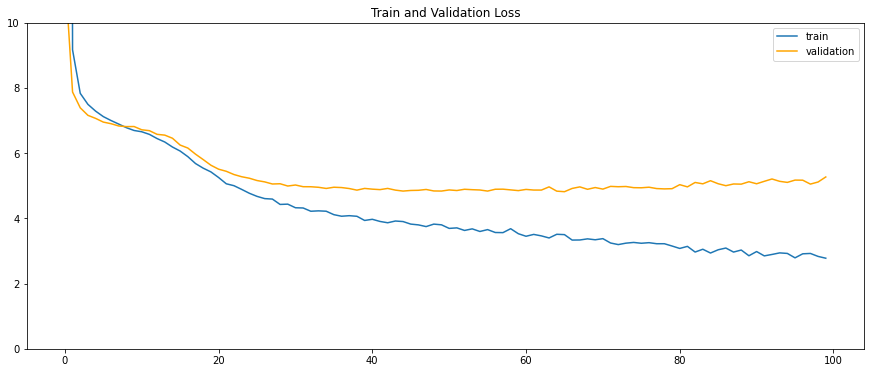

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,6))
x_loss_eval = [x for x in range(0,len(loss_eval))]
x_loss_train = [x for x in range(0,len(loss_train))]
sns.lineplot(x=x_loss_train, y=loss_train, label="train", estimator=None)
sns.lineplot(x=x_loss_eval, y=loss_eval, color="orange", label="validation", estimator=None)
plt.legend()
plt.title("Train and Validation Loss")
plt.ylim(0,10)
plt.savefig("train val loss.png", format="png")
plt.show()

In [0]:
import pandas as pd
data_res_test = pd.DataFrame({
      'actual':data_actual,
      'predicted':data_predicted
    })

In [0]:
data_res_test.to_csv('data_res_test_4.csv', index=False)

In [2]:
import tensorflow.compat.v1 as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14479197947065880436, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7959554828883341420
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7195032768767373363
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12526720271695202124
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]